In [1]:
!pip install segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
from glob import glob
from PIL import Image

# ISIC 2018 Dataset
class ISICDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: Path to dataset directory (e.g., '/kaggle/input/isic2018-challenge-task1-data-segmentation')
            split: 'train', 'val', or 'test'
            transform: albumentations transform
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # ISIC dataset only has train ground truth, so we'll split it ourselves
        if split in ['train', 'val']:
            # Use training data and split it
            img_dir = os.path.join(root_dir, 'ISIC2018_Task1-2_Training_Input')
            mask_dir = os.path.join(root_dir, 'ISIC2018_Task1_Training_GroundTruth')

            # Get all image files
            all_images = sorted(glob(os.path.join(img_dir, '*.jpg')))

            # Split 80-20 for train/val
            split_idx = int(len(all_images) * 0.8)
            if split == 'train':
                self.images = all_images[:split_idx]
            else:  # val
                self.images = all_images[split_idx:]

            # Get corresponding mask paths
            self.masks = []
            for img_path in self.images:
                img_name = os.path.basename(img_path).replace('.jpg', '_segmentation.png')
                mask_path = os.path.join(mask_dir, img_name)
                self.masks.append(mask_path)

        elif split == 'test':
            # Test set has no ground truth
            img_dir = os.path.join(root_dir, 'ISIC2018_Task1_Test_Input')
            self.images = sorted(glob(os.path.join(img_dir, '*.jpg')))
            self.masks = [None] * len(self.images)

        print(f"{split.capitalize()} dataset: {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask if available
        if self.masks[idx] is not None and os.path.exists(self.masks[idx]):
            # Load mask - ISIC masks are grayscale with values 0 or 255
            mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

            # IMPORTANT: Normalize to 0 and 1 (binary)
            # Masks can have values 0-255, we need 0 or 1
            mask = (mask > 0).astype(np.float32)
        else:
            # Create dummy mask for test set
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        # Apply augmentations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # Add channel dimension to mask
        return image, mask.unsqueeze(0).float()

# Augmentation transforms
def get_train_transform(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.GaussNoise(p=0.2),
        A.ElasticTransform(alpha=1, sigma=50, p=0.3),
        A.GridDistortion(p=0.3),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_transform(img_size=256):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

# Metrics for binary segmentation
def dice_score(pred, target, threshold=0.5, smooth=1e-6):
    """Dice coefficient for binary segmentation"""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """IoU (Jaccard) score for binary segmentation"""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def threshold_jaccard(pred, target, threshold=0.5, jaccard_threshold=0.65):
    """Threshold Jaccard metric used in ISIC 2018 Challenge"""
    jaccard = iou_score(pred, target, threshold)
    # If Jaccard < 0.65, count as 0 (failure)
    return jaccard if jaccard >= jaccard_threshold else 0.0

def pixel_accuracy(pred, target, threshold=0.5):
    """Pixel-wise accuracy"""
    pred = (pred > threshold).float()
    correct = (pred == target).sum()
    total = target.numel()
    return (correct / total).item()

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    dice_scores = []
    iou_scores = []

    for imgs, masks in tqdm(loader, desc="Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate metrics
        with torch.no_grad():
            preds = torch.sigmoid(outputs)
            dice_scores.append(dice_score(preds, masks))
            iou_scores.append(iou_score(preds, masks))

    return total_loss / len(loader), np.mean(dice_scores), np.mean(iou_scores)

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    dice_scores = []
    iou_scores = []
    thresh_jaccard_scores = []
    acc_scores = []

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            dice_scores.append(dice_score(preds, masks))
            iou_scores.append(iou_score(preds, masks))
            thresh_jaccard_scores.append(threshold_jaccard(preds, masks))
            acc_scores.append(pixel_accuracy(preds, masks))

    return (total_loss / len(loader),
            np.mean(dice_scores),
            np.mean(iou_scores),
            np.mean(thresh_jaccard_scores),
            np.mean(acc_scores))

# Visualization
def visualize_predictions(model, loader, device, n_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.sigmoid(outputs)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(n_samples, len(imgs))):
        # Denormalize image
        img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0].cpu(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted mask (raw probability)
        axes[i, 2].imshow(preds[i, 0].cpu(), cmap='gray')
        axes[i, 2].set_title('Prediction (Probability)')
        axes[i, 2].axis('off')

        # Overlay
        pred_binary = (preds[i, 0].cpu().numpy() > 0.5).astype(np.uint8)
        overlay = img.copy()
        overlay[pred_binary == 1] = overlay[pred_binary == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

        dice = dice_score(preds[i:i+1], masks[i:i+1])
        iou = iou_score(preds[i:i+1], masks[i:i+1])

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f'Overlay\nDice: {dice:.3f}, IoU: {iou:.3f}')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda
Loading ISIC 2018 dataset...
Train dataset: 2075 images
Val dataset: 519 images
Creating UnetPlusPlus model with resnet34 encoder...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


Epoch 1/1


Validation: 100%|██████████| 33/33 [02:08<00:00,  3.88s/it]


Train Loss: 0.7613, Train Dice: 0.7728, Train IoU: 0.6493
Val Loss: 0.5176, Val Dice: 0.8680, Val IoU: 0.7697
Val Threshold Jaccard: 0.7348, Val Accuracy: 0.9340
Best model saved! Dice: 0.8680


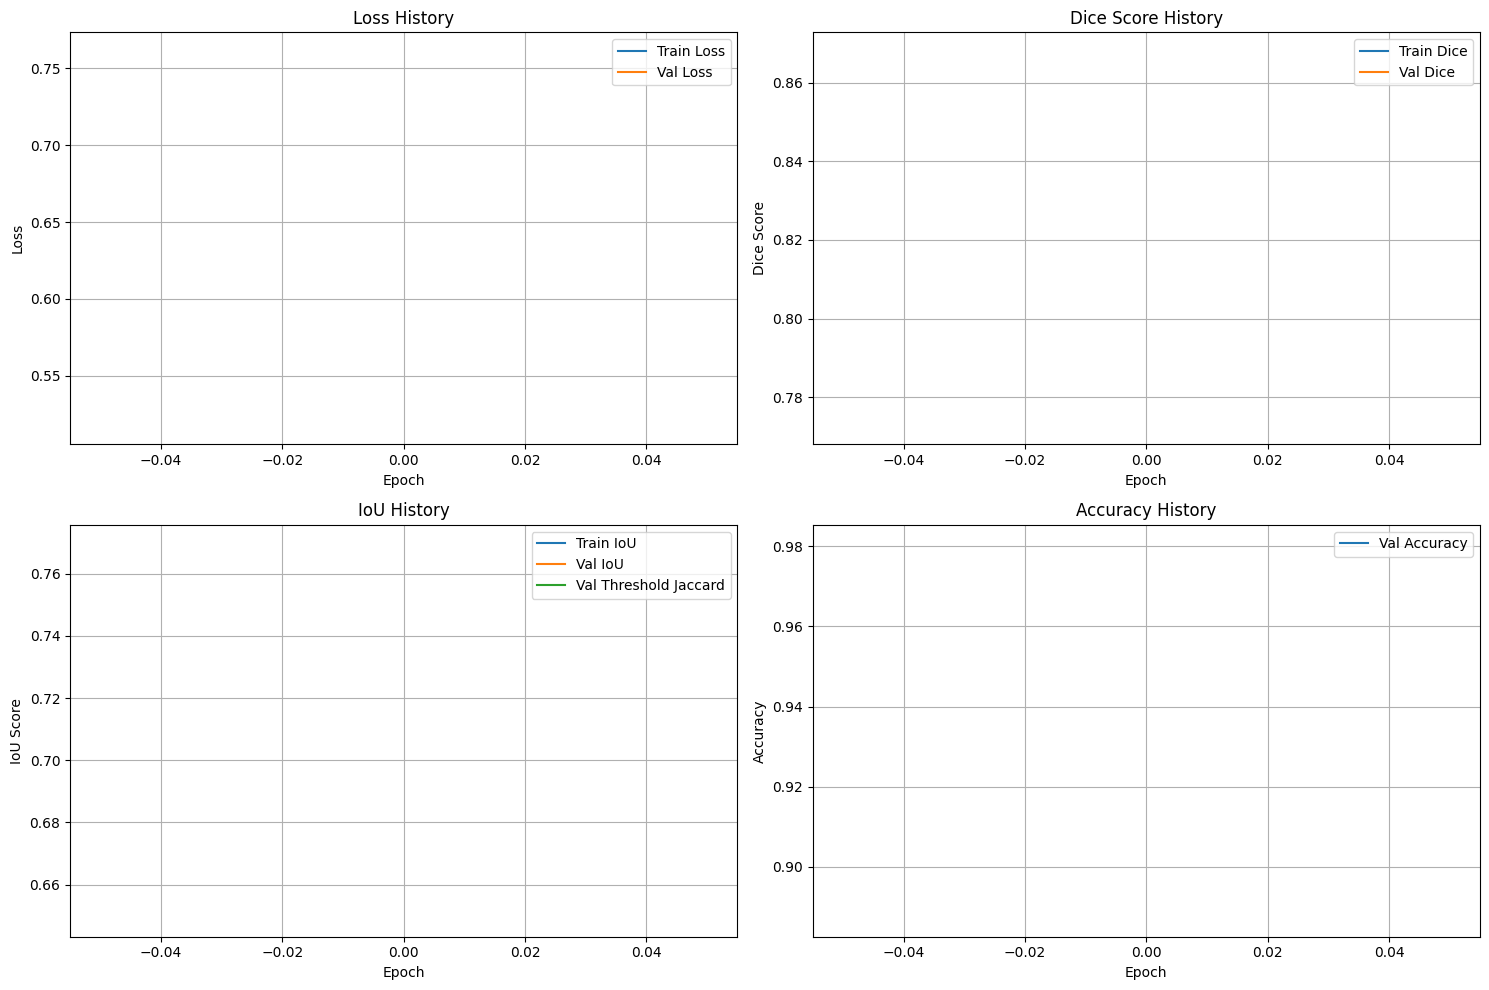


Visualizing predictions...


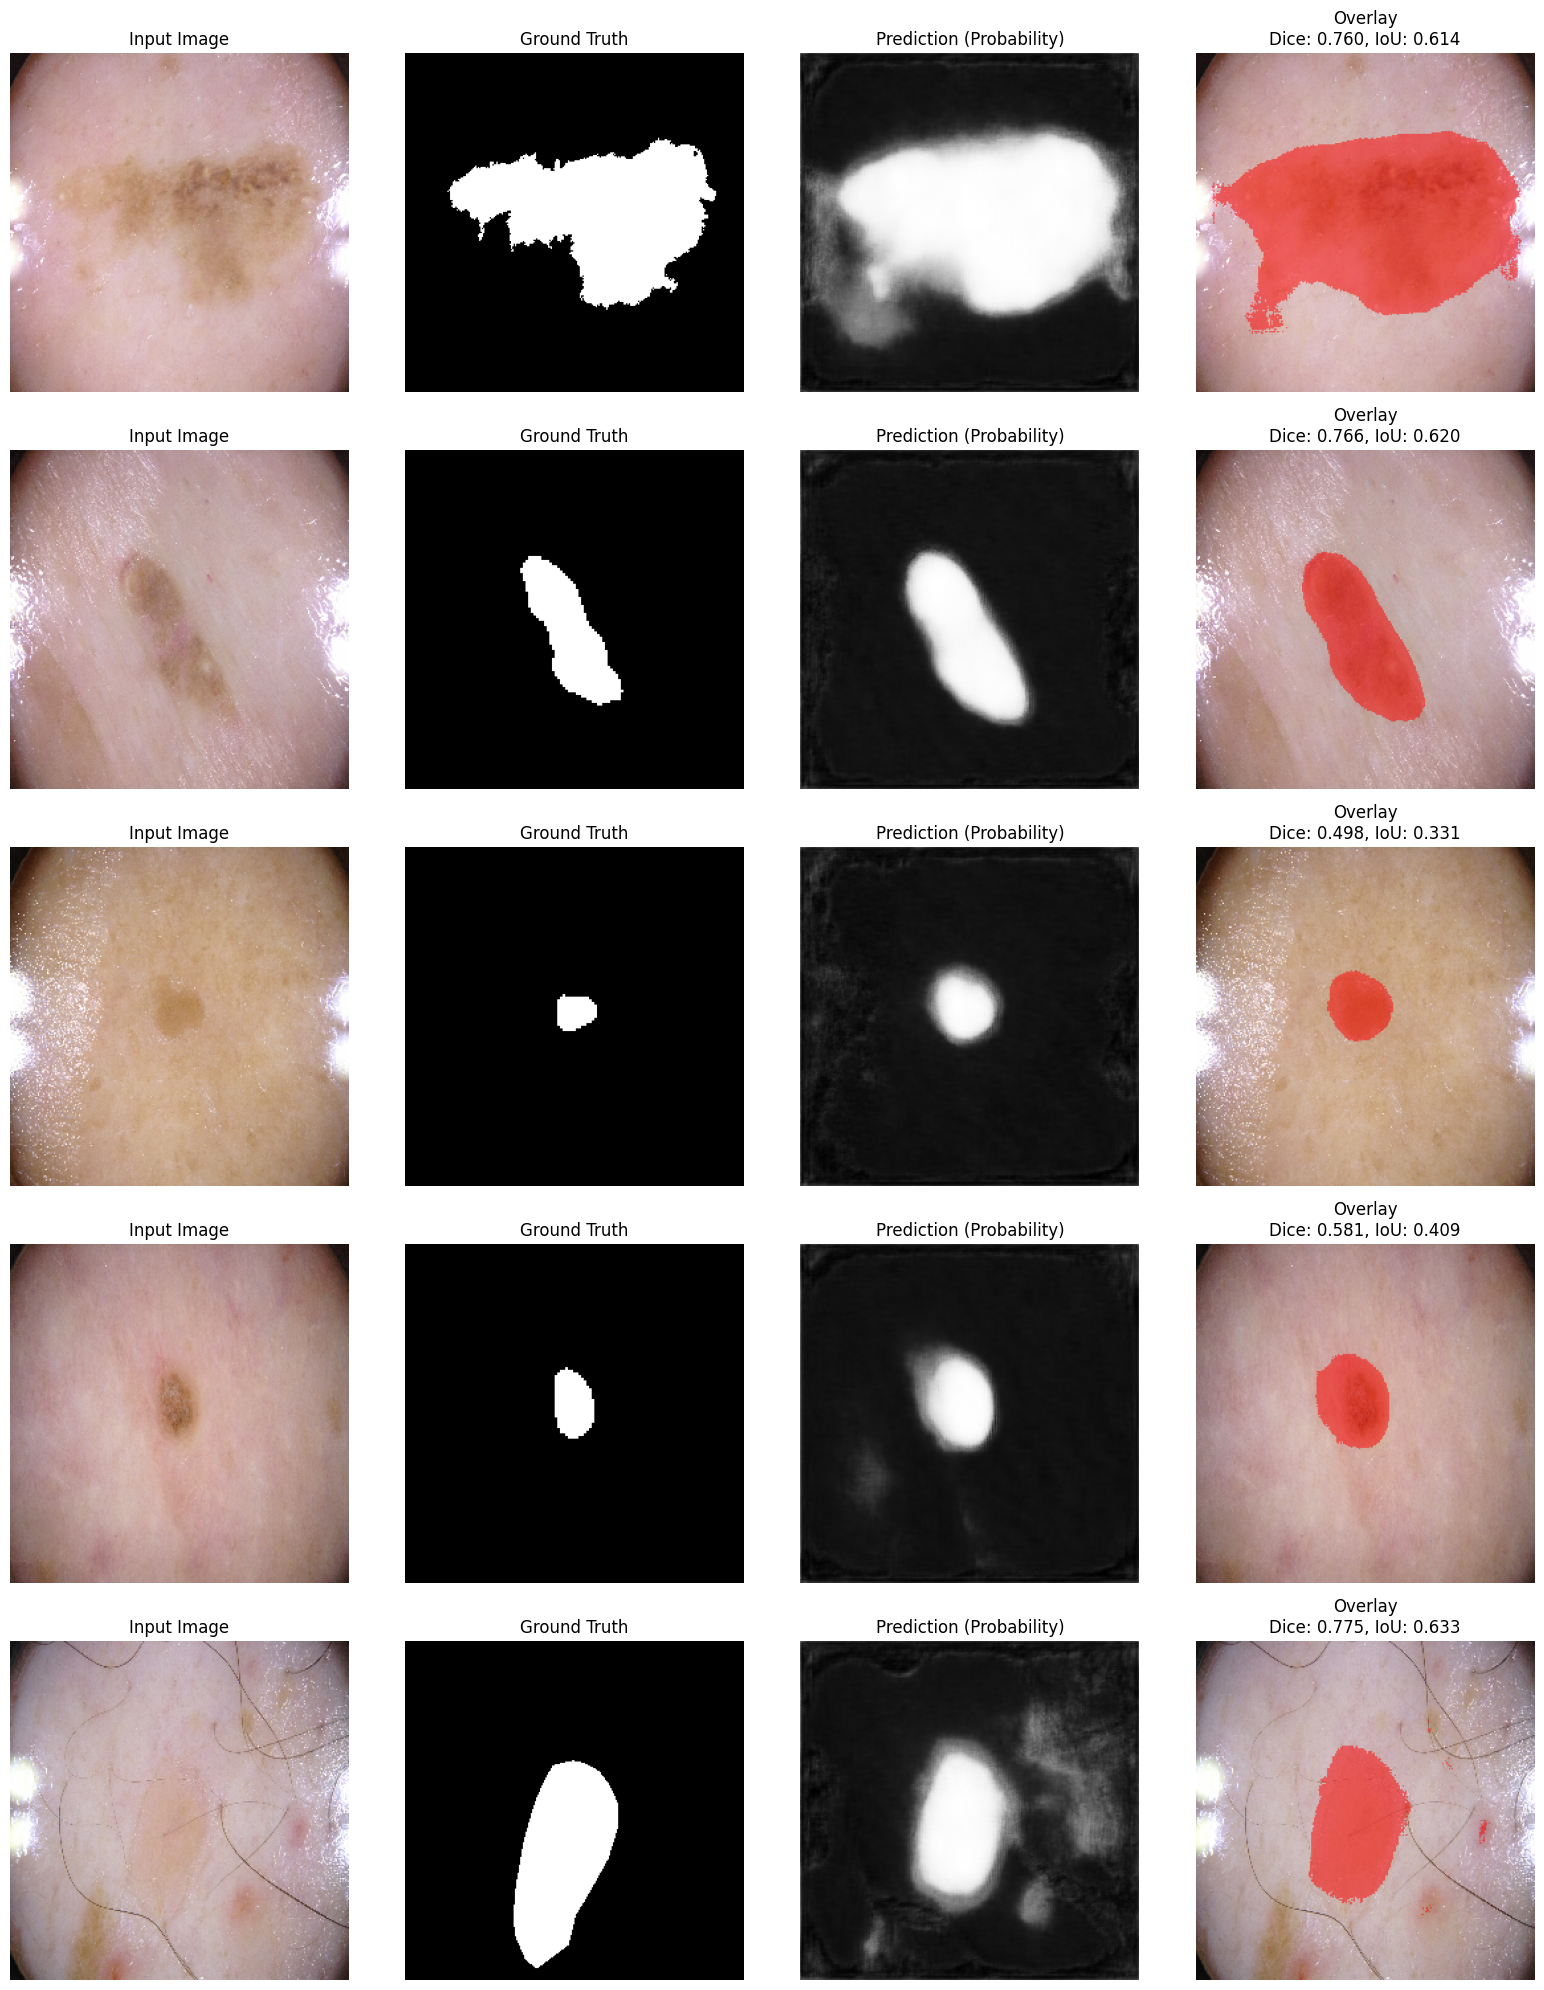


Training complete! Best validation Dice: 0.8680


In [3]:
# Main pipeline
def main():
    # Hyperparameters
    BATCH_SIZE = 16
    EPOCHS = 1
    LR = 1e-4
    IMG_SIZE = 256

    # Path to dataset (adjust for your Kaggle notebook)
    DATASET_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation'

    # Model configuration
    ARCHITECTURE = "UnetPlusPlus"  # Unet, UnetPlusPlus, FPN, DeepLabV3Plus, MAnet
    ENCODER = "resnet34"  # resnet34, resnet50, efficientnet-b0, mobilenet_v2
    ENCODER_WEIGHTS = "imagenet"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Check if dataset exists
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset not found at {DATASET_PATH}")
        print("Please add the ISIC 2018 Task 1 dataset to your Kaggle notebook")
        return

    # Create datasets
    print("Loading ISIC 2018 dataset...")
    train_dataset = ISICDataset(
        root_dir=DATASET_PATH,
        split='train',
        transform=get_train_transform(IMG_SIZE)
    )
    val_dataset = ISICDataset(
        root_dir=DATASET_PATH,
        split='val',
        transform=get_val_transform(IMG_SIZE)
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Create model for binary segmentation
    print(f"Creating {ARCHITECTURE} model with {ENCODER} encoder...")
    model = smp.create_model(
        arch=ARCHITECTURE,
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=1,  # Binary segmentation (lesion vs background)
    ).to(device)

    # Loss function - combination works best for medical imaging
    dice_loss = smp.losses.DiceLoss(mode='binary')
    bce_loss = nn.BCEWithLogitsLoss()

    def combined_loss(pred, target):
        return dice_loss(pred, target) + bce_loss(pred, target)

    criterion = combined_loss

    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    # Training loop
    train_losses, val_losses = [], []
    train_dices, train_ious = [], []
    val_dices, val_ious, val_thresh_jaccards, val_accs = [], [], [], []
    best_dice = 0

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_dice, val_iou, val_thresh_jaccard, val_acc = validate(
            model, val_loader, criterion, device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        train_ious.append(train_iou)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        val_thresh_jaccards.append(val_thresh_jaccard)
        val_accs.append(val_acc)

        scheduler.step(val_dice)

        print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
        print(f"Val Threshold Jaccard: {val_thresh_jaccard:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_isic_model.pth')
            print(f"Best model saved! Dice: {best_dice:.4f}")

    # Plot training history
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].set_title('Loss History')
    axes[0, 0].grid(True)

    # Dice Score
    axes[0, 1].plot(train_dices, label='Train Dice')
    axes[0, 1].plot(val_dices, label='Val Dice')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].set_title('Dice Score History')
    axes[0, 1].grid(True)

    # IoU Score
    axes[1, 0].plot(train_ious, label='Train IoU')
    axes[1, 0].plot(val_ious, label='Val IoU')
    axes[1, 0].plot(val_thresh_jaccards, label='Val Threshold Jaccard')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU Score')
    axes[1, 0].legend()
    axes[1, 0].set_title('IoU History')
    axes[1, 0].grid(True)

    # Accuracy
    axes[1, 1].plot(val_accs, label='Val Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].set_title('Accuracy History')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Visualize predictions
    print("\nVisualizing predictions...")
    visualize_predictions(model, val_loader, device, n_samples=5)

    print(f"\nTraining complete! Best validation Dice: {best_dice:.4f}")

if __name__ == "__main__":
    main()